## Grokking Replication 2

In [1]:
import os
import sys
from functools import partial
from pathlib import Path

import einops
import numpy as np
import torch as t
import torch.nn.functional as F
import torch.optim as optim
from huggingface_hub import hf_hub_download
from jaxtyping import Float
from torch import Tensor
from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import to_numpy
import matplotlib.pyplot as plt

In [2]:
def cross_entropy_high_precision(logits, labels):
    # From https://github.com/callummcdougall/ARENA_3.0
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(t.float64), dim=-1)
    prediction_logprobs = t.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -t.mean(prediction_logprobs)
    return loss

In [3]:
device='cuda'

In [4]:
p = 17
weight_decay=1.0

cfg = HookedTransformerConfig(
    n_layers=1,
    d_vocab=p + 1,
    d_model=128,
    d_mlp=4 * 128,
    n_heads=4,
    d_head=128 // 4,
    n_ctx=3,
    act_fn="relu",
    normalization_type=None,
    device=device,
)

In [5]:
def target_fn(x, y): return (x+y)%p

In [6]:
all_data = t.tensor([(i, j, p) for i in range(p) for j in range(p)]).to(device)
labels = t.tensor([target_fn(i, j) for i, j, _ in all_data]).to(device)

In [7]:
all_data.shape, labels.shape

(torch.Size([289, 3]), torch.Size([289]))

In [8]:
train_split=0.5

cutoff=int(np.floor(train_split*len(labels)))
rI=np.arange(len(labels))
np.random.shuffle(rI)
x_train=all_data[rI[:cutoff]]; y_train=labels[rI[:cutoff]]
x_test=all_data[rI[cutoff:]]; y_test=labels[rI[cutoff:]]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([144, 3]),
 torch.Size([144]),
 torch.Size([145, 3]),
 torch.Size([145]))

In [9]:
model = HookedTransformer(cfg)
model.train()

# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr = 0.001, weight_decay=weight_decay, betas=(0.9, 0.98))


num_steps=15000
print_period=100

res={'loss_test':[], 'loss_train':[], 'accuracy_train':[], 'accuracy_test':[]}
for step in range(num_steps):
    logits_test=model(x_test)
    res['loss_test'].append(cross_entropy_high_precision(logits_test[:, -1, :-1], y_test).item())
    res['accuracy_test'].append(((logits_test[:,-1, :-1].detach().argmax(1)==y_test).sum()/len(y_test)).item())

    logits=model(x_train)
    res['accuracy_train'].append(((logits[:,-1, :-1].detach().argmax(1)==y_train).sum()/len(y_train)).item())
    loss=cross_entropy_high_precision(logits[:, -1, :-1], y_train)
    res['loss_train'].append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step%print_period==0:
        print('step=', str(step) , [k+'='+str(round(res[k][-1], 5)) for k in res.keys()])


step= 0 ['loss_test=2.83784', 'loss_train=2.83602', 'accuracy_train=0.07639', 'accuracy_test=0.04138']
step= 100 ['loss_test=20.6442', 'loss_train=0.00141', 'accuracy_train=1.0', 'accuracy_test=0.09655']
step= 200 ['loss_test=17.02832', 'loss_train=0.00151', 'accuracy_train=1.0', 'accuracy_test=0.11034']
step= 300 ['loss_test=16.08006', 'loss_train=0.00045', 'accuracy_train=1.0', 'accuracy_test=0.14483']
step= 400 ['loss_test=15.38734', 'loss_train=0.00014', 'accuracy_train=1.0', 'accuracy_test=0.1931']
step= 500 ['loss_test=15.21699', 'loss_train=5e-05', 'accuracy_train=1.0', 'accuracy_test=0.22759']
step= 600 ['loss_test=15.21162', 'loss_train=2e-05', 'accuracy_train=1.0', 'accuracy_test=0.24138']
step= 700 ['loss_test=15.28352', 'loss_train=1e-05', 'accuracy_train=1.0', 'accuracy_test=0.26897']
step= 800 ['loss_test=15.38659', 'loss_train=0.0', 'accuracy_train=1.0', 'accuracy_test=0.28966']
step= 900 ['loss_test=15.5231', 'loss_train=0.0', 'accuracy_train=1.0', 'accuracy_test=0.3172

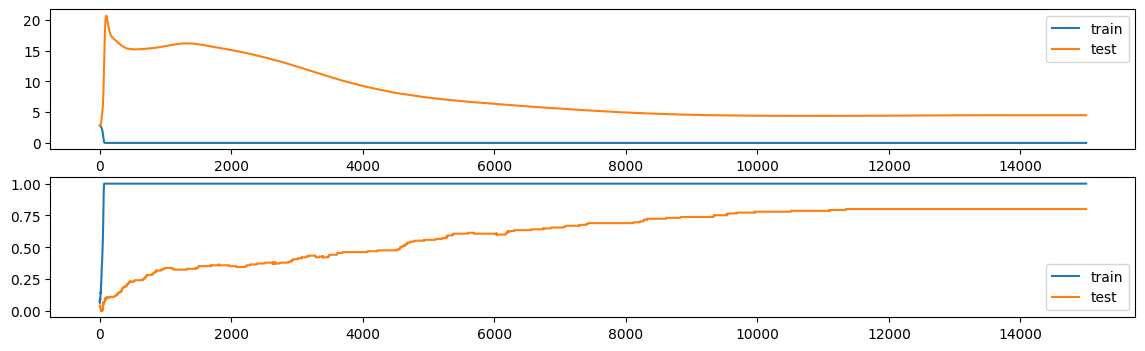

In [10]:
fig=plt.figure(0, (14, 4))
fig.add_subplot(2, 1, 1)
plt.plot(res['loss_train']); plt.plot(res['loss_test']); plt.legend(['train', 'test'])

fig.add_subplot(2, 1, 2)
plt.plot(res['accuracy_train']); plt.plot(res['accuracy_test']); plt.legend(['train', 'test'])

- Ok, so there's grokking! Looks pretty similiar to the results in the Arena course...
- Intuitively it feels like I should probably try to get things as similar as possible?